In [1]:
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 1. Load Accelerometer Data 
##  Dataset is a vector of 151 accelerometer values for each axis. 

In [2]:
data =np.load("dataset/acc_data.npy")

In [3]:
x_axis_data = data[:,:151]

In [4]:
x_axis_data.shape

(11771, 151)

In [5]:
y_axis_data = data[:,151:302]

In [6]:
y_axis_data.shape

(11771, 151)

In [7]:
z_axis_data = data[:,302:453]

In [8]:
z_axis_data.shape

(11771, 151)

## Data labels contain 3 columns, we use only first column to classify human activities

In [9]:
Labels =np.load("dataset/acc_labels.npy")

In [10]:
Labels

array([[ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       ...,
       [17, 30,  6],
       [17, 30,  6],
       [17, 30,  6]], dtype=uint8)

In [11]:
hum_act_labels = Labels[:,0]

In [12]:
hum_act_labels

array([ 1,  1,  1, ..., 17, 17, 17], dtype=uint8)

## Class names

In [13]:
names =np.load("dataset/acc_names.npy",allow_pickle=True)

In [14]:
names

array([[array(['Standing up from sitting'], dtype='<U24'),
        array(['Standing up from laying'], dtype='<U23'),
        array(['Walking'], dtype='<U7'), array(['Running'], dtype='<U7'),
        array(['Going upstairs'], dtype='<U14'),
        array(['Jumping'], dtype='<U7'),
        array(['Going downstairs'], dtype='<U16'),
        array(['Lying down from standing'], dtype='<U24'),
        array(['Sitting down'], dtype='<U12'),
        array(['Generic falling forward'], dtype='<U23'),
        array(['Falling rightward'], dtype='<U17'),
        array(['Generic falling backward'], dtype='<U24'),
        array(['Hitting an obstacle in the fall'], dtype='<U31'),
        array(['Falling with protection strategies'], dtype='<U34'),
        array(['Falling backward-sitting-chair'], dtype='<U30'),
        array(['Syncope'], dtype='<U7'),
        array(['Falling leftward'], dtype='<U16')],
       [array(['StandingUpFS'], dtype='<U12'),
        array(['StandingUpFL'], dtype='<U12'),
      

In [15]:
names.shape

(2, 17)

In [16]:
class_names = names[0:1,:]

In [17]:
class_names

array([[array(['Standing up from sitting'], dtype='<U24'),
        array(['Standing up from laying'], dtype='<U23'),
        array(['Walking'], dtype='<U7'), array(['Running'], dtype='<U7'),
        array(['Going upstairs'], dtype='<U14'),
        array(['Jumping'], dtype='<U7'),
        array(['Going downstairs'], dtype='<U16'),
        array(['Lying down from standing'], dtype='<U24'),
        array(['Sitting down'], dtype='<U12'),
        array(['Generic falling forward'], dtype='<U23'),
        array(['Falling rightward'], dtype='<U17'),
        array(['Generic falling backward'], dtype='<U24'),
        array(['Hitting an obstacle in the fall'], dtype='<U31'),
        array(['Falling with protection strategies'], dtype='<U34'),
        array(['Falling backward-sitting-chair'], dtype='<U30'),
        array(['Syncope'], dtype='<U7'),
        array(['Falling leftward'], dtype='<U16')]], dtype=object)

In [18]:
class_names.shape

(1, 17)

# VLAD Feature Encoding Technique

In [19]:
def sliding_window(data):
    window_size = 40
    stride = 10
    return np.lib.stride_tricks.sliding_window_view(data,window_size)[::stride,:]

In [20]:
def GMM(data):
    gmm = GaussianMixture(n_components=12, covariance_type='spherical').fit(data)
    return gmm.means_

In [21]:
def find_NearestNeighbour(localdes,neighborhood):
    """
    Finds the nearest neighborhood of a vector.
    Args:
        point (float array): The initial point.
        neighborhood (numpy float matrix): The points that are around the initial point.
    Returns:
        float array: The point that is the nearest neighbor of the initial point.
        integer: Index of the nearest neighbor inside the neighborhood list
    """
    min_distance = float('inf')
    NearestNeighbour = neighborhood[0]
    NearestN_index = 0
    for i in range(len(neighborhood)):
        neighbor = neighborhood[i]
        distance = cv2.norm(localdes - neighbor)
        if distance < min_distance:
            min_distance = distance
            NearestNeighbour = neighbor
            NearestN_index = i 
    return NearestNeighbour, NearestN_index          

In [22]:
def vlad (localdescriptors, centers):
    """
    Calculate the Vector of Locally Aggregated Descriptors (VLAD) which is a global descriptor from a group of
    descriptors and centers that are codewords of a codebook, obtained for example with K-Means.
    Args:
        descriptors (numpy float matrix): The local descriptors.
        centers (numpy float matrix): The centers are points representatives of the classes.
    Returns:
        numpy float array: The VLAD vector.
    """    
        
    dimensions = len(localdescriptors[0])
    vlad_vector = np.zeros((len(centers), dimensions), dtype=np.float32)
    for localdescriptors in localdescriptors:
        nearest_center, center_index = find_NearestNeighbour(localdescriptors,centers)
        for i in range(dimensions):
            vlad_vector[center_index][i] += (localdescriptors[i] - nearest_center[i])
    # L2 Normalization            
    vlad_vector = cv2.normalize(vlad_vector,vlad_vector)
    vlad_vector = vlad_vector.flatten()
    return vlad_vector   
        

In [23]:
    #sliding window in every row
slide_vec = sliding_window(x_axis_data[0])
    #GMM in slide_vec shape 12X30
slide_vec.shape

(12, 40)

## X_axis 

In [24]:
xfeaturevector = np.zeros((11771,480))
for i in range(x_axis_data.shape[0]):
    #sliding window in every row
    slide_vec = sliding_window(x_axis_data[i])
    #GMM in slide_vec shape 12X30
    codebook = GMM(slide_vec)
    #vlad implement retirn 480 dimensions
    v = vlad(slide_vec,codebook) 
    xfeaturevector[i] = v


## K*D dimensions, K=12,D=40, and K*D=480

In [25]:
xfeaturevector.shape

(11771, 480)

In [26]:
xfeaturevector

array([[ 0.07585517,  0.07186279,  0.07186279, ..., -0.00174667,
         0.00112286,  0.00212095],
       [ 0.00038771,  0.00031722,  0.00211479, ...,  0.00310169,
         0.00281972,  0.00239676],
       [ 0.10025028,  0.10025028,  0.10025028, ...,  0.0087719 ,
         0.01002503,  0.01002503],
       ...,
       [ 0.01267231,  0.01267231,  0.01267231, ...,  0.02995272,
         0.03456083,  0.03916894],
       [ 0.02744669,  0.02973392,  0.02973392, ...,  0.02515947,
         0.02287225,  0.02515947],
       [-0.05946103, -0.01600874,  0.04116533, ...,  0.02286963,
         0.02286963,  0.02286963]])

## Y_axis 

In [27]:
yfeaturevector = np.zeros((11771,480))
for i in range(y_axis_data.shape[0]):
    #sliding window in every row
    slide_vec = sliding_window(y_axis_data[i])
    #GMM in slide_vec shape 12X30
    codebook = GMM(slide_vec)
    #vlad implement retirn 480 dimensions
    v = vlad(slide_vec,codebook) 
    yfeaturevector[i] = v


## K*D dimensions, K=12,D=40, and K*D=480

In [28]:
yfeaturevector.shape

(11771, 480)

In [29]:
yfeaturevector

array([[ 0.05162067,  0.0607302 ,  0.06680322, ...,  0.04554765,
         0.04554765,  0.04858416],
       [ 0.0220235 ,  0.01908704,  0.0176188 , ...,  0.04991994,
         0.04991994,  0.04991994],
       [ 0.02451349,  0.01685302,  0.0114907 , ...,  0.04596279,
         0.0428986 ,  0.0428986 ],
       ...,
       [-0.07388702, -0.12503958, -0.13640681, ..., -0.01349859,
        -0.01349859, -0.01420904],
       [-0.00721167, -0.00600972, -0.00881426, ..., -0.01522463,
        -0.01522463, -0.01522463],
       [ 0.05010617,  0.05344658,  0.05344658, ..., -0.01586695,
        -0.01503185, -0.01586695]])

## Z_axis 

In [30]:
zfeaturevector =np.zeros((11771,480))
for i in range(z_axis_data.shape[0]):
    #sliding window in every row
    slide_vec = sliding_window(z_axis_data[i])
    #GMM in slide_vec shape 12X30
    codebook = GMM(slide_vec)
    #vlad implement retirn 480 dimensions
    v = vlad(slide_vec,codebook) 
    zfeaturevector[i] = v


## K*D dimensions, K=12,D=40, and K*D=480

In [31]:
zfeaturevector.shape

(11771, 480)

In [32]:
zfeaturevector

array([[-0.00537203, -0.01074406, -0.01487639, ..., -0.05619968,
        -0.05289382, -0.05289382],
       [-0.0464424 , -0.04953856, -0.0464424 , ..., -0.0464424 ,
        -0.0464424 , -0.0464424 ],
       [-0.04878874, -0.05165866, -0.05165866, ..., -0.05165866,
        -0.04878874, -0.04878874],
       ...,
       [ 0.06616841,  0.06616841,  0.07125829, ...,  0.00636235,
         0.00827105,  0.00636235],
       [ 0.05536107,  0.05536107,  0.05536107, ...,  0.00245088,
         0.00216254,  0.00216254],
       [-0.00111981,  0.07614684,  0.10750142, ...,  0.05375071,
         0.05375071,  0.05375071]])

# CONCATENATE AXIS

In [33]:
final_feature_vector = np.concatenate((xfeaturevector,yfeaturevector,zfeaturevector),axis=1)
final_feature_vector.shape

(11771, 1440)

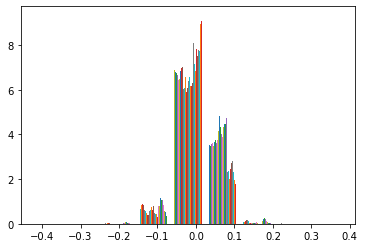

In [34]:
pyplot.hist(final_feature_vector,bins = 9,density = True)
pyplot.show()

# Data splitting

In [46]:
train_data, test_data, train_labels, test_labels = train_test_split(final_feature_vector, hum_act_labels, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=0)
print("Labels for training and testing data")
print(len(train_data))
print(len(test_data))

Labels for training and testing data
9416
2355


In [47]:
print(len(train_labels))
print(len(test_labels))

9416
2355


In [48]:
labels = np.unique(train_labels)
print(labels) 

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [49]:
model = SVC(kernel='linear')

In [50]:
model.fit(train_data, train_labels)

SVC(kernel='linear')

In [51]:
predictionstrain = model.predict(train_data)
print(predictionstrain)
print(train_labels)

[ 5 10 14 ... 10  7  4]
[ 5 10 17 ... 11 17  4]


In [52]:
percentage_train = model.score(train_data, train_labels)

In [53]:
predictionstest = model.predict(test_data)
print(predictionstest)
print(test_labels)

[14 11  3 ...  3 15 10]
[14 12  3 ...  1 15  5]


In [54]:
percentage_test = model.score(test_data, test_labels)

In [55]:
from sklearn.metrics import confusion_matrix
res = confusion_matrix(test_labels, predictionstest)
print("Confusion Matrix")
print(res)
print(f"Test Set: {len(test_data)}")
print(f"Training Accuracy = {percentage_train*100} %")
print(f"Testing Accuracy = {percentage_test*100} %")

Confusion Matrix
[[  5   3   3   4   0   0   5   0   1   0   1   2   0   1   2   0   0]
 [  0  14   6   3   2   0  13   0   1   0   0   1   1   2   2   1   0]
 [  0   0 186  92  10   3  29   0   0   1   2   2   1   0   2   0   0]
 [  0   0 107 240   9   7  44   0   0   1   0   1   1   0   0   0   0]
 [  1   1  65  42  30   4  35   0   0   6   0   0   3   0   3   0   1]
 [  2   0  38  37  11  14  17   0   0   1   1   0   1   1   1   1   0]
 [  0   1  68 104   9   4  69   0   0   0   0   2   0   1   1   0   0]
 [  1   5   8   9   5   3   6   6   2   2   2   2   1   0   4   3   0]
 [  1   2   6   3   5   0   5   6   4   1   1   1   1   0   6   1   1]
 [  0   0   7   3   6   2   2   1   0  48  11   2   3  24   2   3   1]
 [  2   0  16  10   3   5   4   1   0  14  26   3   2   7   4   8   2]
 [  1   1  12   6   7   4   8   2   1  10   8  26   1   2  13   8   5]
 [  1   0  14  11   6   3   1   1   2   4   3   9  43   5   1   6   2]
 [  0   0   4   6   6   3   1   2   1  27   5   2   2  35   